# Chapter 7. Ensemble Learning & Random Forests

Suppose we ask a random question to thousands of people, then aggregate their answers. In many cases we will find that this aggregated answer is better than an **expert's answer** (*really*). This is called the *wisdom of the crowd*.

Similarly, if we aggregate the predictions of a group of models (such as classifiers or regressors), we will often get better predictions than the best individual predictor.

A group of predictors is called an ensemble. Thus this technique is called **ensemble learning**, and an ensemble learning algorithm is called an **Ensemble Method**.

As an example of an ensemble method, we can train a group of decision tree classifiers, each on a *random subset* of the training data. Such an ensemble of decision trees is called a **random forest**. Despite its simplicity, this is one of the most powerful machine learning algorithms available today.

You will often use ensemble methods near the end of a project, once you have already built a few good predictors, to combine them into an even better predictor.

In this chapter, we will discuss the most famous ensemble learning methods, including: **Bagging, Boosting, & Stacking**.

## Voting Classifiers

Suppose we have trained a few classifiers, each achieving an 80% accuracy. A very simple way to create an even better classifiers is to aggregate the predictions of all our classifiers and choose the prediction that is the most frequent.

Majority voting classification is called **Hard Voting**:

<div style="text-align:center;"><img style="width: 50%;" src="static/imgs/Hard_voting.png"></div>

Somewhat surprisingly, this classifier achieves an even better accuracy than the best predictor in the ensemble. Even if each classifier is a weak learner (does slightly better then random guessing). Assuming that we have a sufficient number of weak learners and enough diversity.

Due to the law of large numbers, if we build an ensemble containing 1,000 classifiers with individual accuracies of $51%$ & trained for binary classification, If we predict the majority voting class, we can hope for up to $75%$ accuracy.

This is only true if all classifiers are completely independent, making uncorrelated errors, which is clearly not the case because they are trained on the same data.

One way to get diverse classifiers is use different algorithms for each one of them & train them on different subset of the training data. 

Let's implement a hard voting ensemble learner using scikit-learn:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

In [3]:
log_clf = LogisticRegression(solver='lbfgs')
rf_clf = RandomForestClassifier(n_estimators=100)
svm_clf = SVC(gamma='scale')

In [4]:
from sklearn import datasets
from sklearn.model_selection import train_test_split

In [5]:
X, y = datasets.make_moons(n_samples=10000, noise=0.5)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33)

In [6]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((6700, 2), (6700,), (3300, 2), (3300,))

In [7]:
voting_clf = VotingClassifier(estimators=[('lr', log_clf), ('rf', rf_clf), ('svc', svm_clf)], voting='hard')

In [8]:
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression()),
                             ('rf', RandomForestClassifier()), ('svc', SVC())])

Let's take a look at the performance of each classifier + ensemble method on the validation set:

In [9]:
from sklearn.metrics import accuracy_score

In [10]:
for clf in [log_clf, rf_clf, svm_clf, voting_clf]:
    clf.fit(X_train, y_train)
    y_hat = clf.predict(X_val)
    print(clf.__class__.__name__, accuracy_score(y_val, y_hat))

LogisticRegression 0.8151515151515152
RandomForestClassifier 0.7972727272727272
SVC 0.8218181818181818
VotingClassifier 0.8203030303030303


There we have it! The voting classifier slightly outperforms the individual classifiers.

If all ensemble method learners can estimate class probabilities, we can average their probabilities per class then predict the class with the highest probability. This is called **Soft voting**. It often yields results better than hard voting because it weights confidence.

## Bagging & Pasting

Another approach to having different algorithms trained on the same dataset is to have one algorithm but trained on random subsets of the training data. 

When subset sampling is performed with replacement, this is called **bagging**, and when sampling is performed without replacement, this is called **Pasting**.

Bagging is showcased in the following figure:

<div style="text-align:center;"><img style="width: 50%;" src="static/imgs/bagging.png"></div>

Once the ensemble method is done training, we can infer using the *mode* for classification or *avg* for regression.

Each individual predictor has a higher bias than if it were trained on the whole training dataset, but aggregation reduces both bias and variance.

Because ensemble learners use separate different algorithms, they can be easily parallalizable, and that is why bagging and pasting are so popular, they scale very well.

### Bagging & Pasting in Scikit-Learn

Let's implement bagging in scikit-learn:

In [11]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

In [12]:
bag_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500, max_samples=100, bootstrap=True, n_jobs=-1)

In [13]:
bag_clf.fit(X_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(), max_samples=100,
                  n_estimators=500, n_jobs=-1)

In [14]:
y_hat = bag_clf.predict(X_val)

Bagging models often result in a slightly more biased model than the base predictor, but because of the diversity of the training subsets, it has much smoother decision curves meaning it has usually a lower variance.

The comparable/slightly higher bias comes from the fact that we are sampling with replacement, leading to points making it to multiple child learners.

The following figure compares a normal decision tree and the same tree but using Bagging:

<div style="text-align:center;"><img style="width:66%;" src="static/imgs/dt_bagging.png"></div>

Overall, bagging produces better models, and this explains why it's very popular. If we have enough compute time and power, we can also use cross validation to test both bagging and pasting for our specific project and decide which works better.

### Out-of-Bag Evaluation

With bagging, some instances will be sampled several times for several predictors, while others won't be sampled at all. Only about 63% of the instances are sampled for each predictor. The other 37% of instances not sampled are called Out-of-Bag (oob) instances. Note that they're not the same 37% for all predictors.

Since the individual predictor never sees the oob samples, it can be evaluated on the oob data without the need for a separate validation set.

We can evaluate the ensemble itself by averaging the oob scores of each predictor.

Let's do this using scikit-learn:

In [15]:
bag_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500, max_samples=0.63, bootstrap=True, n_jobs=-1, oob_score=True)

In [16]:
bag_clf.fit(X_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(), max_samples=0.63,
                  n_estimators=500, n_jobs=-1, oob_score=True)

In [17]:
bag_clf.oob_score_

0.8040298507462686

Let's verify this estimation using the validation set:

In [18]:
y_hat = bag_clf.predict(X_val)

In [19]:
accuracy_score(y_val, y_hat)

0.7993939393939394

Close enough!

The oob decision function is also available using scikit-learn's API, since our classifier is a decision tree then the decision function is a ratio that can be expressed as a probability, let's take a look at it for each instance:

In [20]:
bag_clf.oob_decision_function_

array([[0.4379562 , 0.5620438 ],
       [0.32684825, 0.67315175],
       [0.        , 1.        ],
       ...,
       [0.32841328, 0.67158672],
       [0.09926471, 0.90073529],
       [0.24820144, 0.75179856]])

## Random Patches & Random Subspaces

We can sample features as well. Sampling is controlled by two hyper-parameters: `max_features` & `bootstrap_features`.

Each predictor will be trained on a random feature sample. This technique is especially useful when you're dealing with high-dimensional input as as imagery. 

Sampling both instances and features is called "random patches" method. Sampling only features is called "random subspaces" method. Sampling features results in a more predictor diversity.

## Random Forests

A random forest is an ensemble of decision trees.

Let's use its scikit-learn implementation:

In [87]:
from sklearn.ensemble import RandomForestClassifier

In [88]:
rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1)

In [89]:
rnd_clf.fit(X_train, y_train)

RandomForestClassifier(max_leaf_nodes=16, n_estimators=500, n_jobs=-1)

In [90]:
y_pred_rf = rnd_clf.predict(X_val)

- The following `BaggingClassifier` is roughly equivalent to the previous `RandomForestClassifier`:

In [91]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(splitter='random', max_leaf_nodes=16),
    n_estimators=500, max_samples=1.0, bootstrap=True, n_jobs=-1
)

In [92]:
accuracy_score(rnd_clf.predict(X_val), y_val)

0.816060606060606

### Extra-Trees

When we are growing a tree in a random forest, only a subset of features are considered when splitting. 

To make the trees more random, we can choose different thresholds of the features rather than searching for the best possible threshold. Such resulting model is called **Extremely Randomized Trees Ensemble**.

We don't really know if an extremely randomized trees model will or will not outperform a classical random forest model. Generally, the only way to know is to try both and check their results using cross validation.

### Feature Importance

Yet another great quality of random forests is that they make it so easy to measure the importance of each feature.

We measure the importance by averaging the reduced impurity of each node that uses a certain feature across all trees in the forest. More exactly it's a weighted average beacuse each node has a number of samples that is used to weight.

Let's get feature importance using random forests on the iris dataset:

In [26]:
from sklearn.datasets import load_iris

In [27]:
iris = load_iris()

In [28]:
rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1)

In [29]:
rnd_clf.fit(iris['data'], iris['target'])

RandomForestClassifier(n_estimators=500, n_jobs=-1)

In [30]:
for name, score in zip(iris['feature_names'], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.10382343392593345
sepal width (cm) 0.023460596089342242
petal length (cm) 0.42498516117244517
petal width (cm) 0.4477308088122791


Let's plot pixel-wise MNIST feature importance:

In [31]:
from sklearn.datasets import load_digits

In [32]:
digits = load_digits()

In [76]:
digits.data.shape
digits.data[0].reshape(8,8).shape

(8, 8)

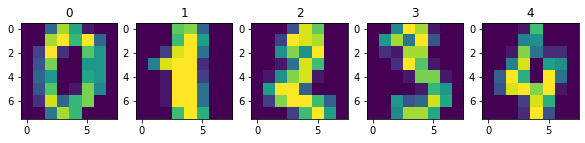

In [74]:
fig, axs = plt.subplots(1,5, figsize=(10,10))
for i in range(5):
    axs[i].imshow(digits.data[i].reshape(8,8))
    axs[i].set_title(digits.target[i])

In [70]:
rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1)

In [83]:
rnd_clf.fit(digits['data'], digits['target'])

RandomForestClassifier(n_estimators=500, n_jobs=-1)

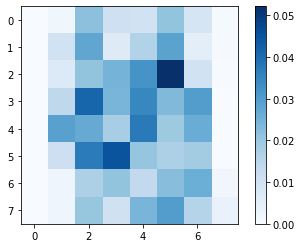

In [84]:
plt.imshow(rnd_clf.feature_importances_.reshape(8,8), cmap='Blues')
plt.colorbar()
plt.show()

Random Forest are very handy to get a quick understanding of what features actually matter, particularly if you need to perform feature selection.

## Boosting

Boosting refers to any ensemble method that can combine several weak learners into a strong learner. The general idea of most boosting methods is to train predictors sequentially, each trying to correct its predecessor. 

There are many boosting methods available, but by far the most popular one is **AdaBoost** (Adaptive boosting) and **gradient boosting**.

Let's start with Adaboost:

### AdaBoost

One way for a new predictor to correct its predecessor is to pay a bit more attention to the training instances that were underfitted. This results in the later predictors focusing more and more on the hard cases (the technique used by Adaboost).

The following figure demenstrates the process

<div style="text-align:center;"><img style="width:50%;" src="static/imgs/adaboost.png"></div>

The algorithm first trains a base classifier and use it to make predictions on the training set. It then increases the weight of the missclassified instances and pass its weights + the data to the next predictor.

This iterative learning approach shares similarities with gradient descent, except in gradient descent we're using the gradients to minimize a cost function, but with `AdaBoost` we're simply adding more learners to the chain. There is one important drawback of this method, It cannot be parallalized because each predictor needs the output of the previous predictor.

Let's take a closer look at the Adaboost Algorithm:

1. Each instance weight $w^{(i)}$ is initially set to $1/m$.
2. A first predictor is trained, and its weighted error rate $r_1$ is computed on the training set using the general formula, where $\hat{y}_j^{(i)}$ is the $j^{th}$ predictor's prediction for the $i^{th}$ instance.

$$r_j=\frac{\sum_{i=1(\hat{y_j^{(i)}}\neq{y^{(i)}})}^{m} w^{(i)}}{\sum_{i=1}^{m}w^{(i)}}$$

3. the predictor's weight $\alpha_{0}$ is computed as follows:

$$\alpha_{j}=\eta log(\frac{1-r_j}{r_j})$$

The more accurate the predictor is, the higher its weight will be. If it's just guessing randomly, then its weight will be close to zero. However, If it's most often wrong, then its weight will be negative.

4. The algorithm updates the instance weights which boosts the weights of the misclassified instances:

$$\forall i \in \{1,2, \dots, m\} \\ w^{(i)} \leftarrow \begin{cases}
w^{(i)},  & \text{if $\hat{y}^{(i)}_j = y^{(i)}$} \\
w^{(i)}exp(\alpha_{j}), & \text{else}
\end{cases}$$

Then all the instance weights are normalized (are divided by the sum of the weights).

5. Finally, a new predictor is trained using the updated weights, and the whole process is repeated again.

The algorithm stops when the desired number of predictors is reached, or when a perfect predictor is found. To make predictions, Adaboost simply computes the predictions of all the predictors and weight them using the predictor weights $\alpha_j$.

The predicted class is the one that receives the majority of the weighted votes (where $N$ is the number of predictors):

$$\hat{y}(x)=argmax_{k}\sum_{j=1 \; \hat{y}_j(x)=k}^{N}\alpha_j$$

Let's use scikit-learn's implementation of Adaboost with 1 depth decision trees:

In [77]:
from sklearn.ensemble import AdaBoostClassifier

In [78]:
ada_clf = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1), 
                             n_estimators=200, algorithm='SAMME.R', 
                             learning_rate=0.5)

In [79]:
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=200)

In [80]:
from sklearn.metrics import accuracy_score

In [81]:
accuracy_score(ada_clf.predict(X_val), y_val)

0.8121212121212121

### Gradient Boosting

Just like Adaboost, Gradient Boosting works by sequentially adding predictors to an ensemble each one correcting its predecessor. However, instead of tweaking the instance weights at every iteration like Adaboost does, this method tries to fit the new predictor to the **residual errors** made by the previous predictor.

Let's go through a simple regression example, First let's fit a decision tree regressor to a synthetically generated training set:

In [93]:
X = np.linspace(start=0, stop=1, num=500)
y = (X-0.5)**2 + np.random.randn(500)/50.
X = X[..., None]  # 1 feature

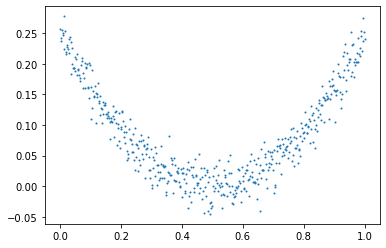

In [94]:
plt.scatter(X.squeeze(), y.squeeze(), s=1)
plt.show()

In [95]:
from sklearn.tree import DecisionTreeRegressor

In [96]:
tree_reg1 = DecisionTreeRegressor(max_depth=2)

In [97]:
tree_reg1.fit(X, y)

DecisionTreeRegressor(max_depth=2)

Next, we'll train a second decision tree regressor on the errors made by the first tree:

In [98]:
y2 = y - tree_reg1.predict(X)

In [99]:
tree_reg2 = DecisionTreeRegressor(max_depth=2)

In [100]:
tree_reg2.fit(X, y2)

DecisionTreeRegressor(max_depth=2)

Now we train a third regressor on the errors made by the second regressor:

In [101]:
y3 = y2 - tree_reg2.predict(X)

In [102]:
tree_reg3 = DecisionTreeRegressor(max_depth=2)

In [103]:
tree_reg3.fit(X, y3)

DecisionTreeRegressor(max_depth=2)

Now we have an ensemble containing three trees. It can make predictions on a new instance simply by adding up the predictions of all the trees:

In [104]:
y_pred = sum(tree.predict(X) for tree in (tree_reg1, tree_reg2, tree_reg3))

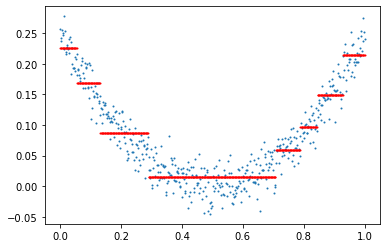

In [111]:
plt.scatter(X.squeeze(), y.squeeze(), s=1)
plt.scatter(X.squeeze(), y_pred.squeeze(), s=1, c='red')
plt.show()

The following figure showcases the predictions made by sequential models, on the left we have gradient boosting, on the right we have Adaboost:

<div style="text-align:center;"><img style="width:66%;" src="static/imgs/boosting_ensembles.png"></div>

A simpler way to train Gradient Boosting Regressor Trees ensemble is to use Scikit-Learn as follows:

In [112]:
from sklearn.ensemble import GradientBoostingRegressor

In [113]:
gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0)

In [114]:
gbrt.fit(X, y)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3)

The learning rate in the hyper-parameters scales the contribution of each tree. If we set it to a low value, we will need more trees in the ensemble to fit the model to the training set, but the predictions will usually generalize better.

For a fixed learning rate, we will have to figure out the optimal number of trees to not underfit/overfit. Early stopping can be used.

<div style="text-align:center;"><img style="width:66%;" src="static/imgs/ensemble_overunderfit.png"></div>

The following code trains a `GBRT` ensemble with 120 trees, then measures the validation error at each stage of training to find the optimal number of trees, and finally trains another GBRT ensemble using the optimal number of trees: 

In [115]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [116]:
X_train, X_val, y_train, y_val = train_test_split(X, y)

In [117]:
gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120)

In [118]:
gbrt.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=2, n_estimators=120)

In [119]:
errors = [mean_squared_error(y_val, y_pred) for y_pred in gbrt.staged_predict(X_val)]

In [120]:
bst_n_estimators = np.argmin(errors) + 1
bst_n_estimators

118

In [121]:
gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=bst_n_estimators)

In [122]:
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=2, n_estimators=118)

Our `argmin` based pick and the resulting model are showcased in the following figure:

<div style="text-align:center;"><img style="width: 66%;" src="static/imgs/gradient_boosting_optimization.png"></div>

It is also possible to implement early stopping by actually stopping early and not export results for a large number of trees then use `argmin`. 

This code stops training when the validation error does not improve for five iterations in a row:

In [123]:
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True)
min_val_error = float("inf")
error_going_up = 0

In [124]:
for n_estimators in range(1, 120):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 5:
            break  # Early Stopping

It's worth noting that an optimized implementation of gradient boosting is available in the popular python library **`XGBoost`** (Stands for Extreme Gradient Boosting).

Let's try it out:

In [126]:
import xgboost

In [127]:
xgb_reg = xgboost.XGBRegressor()

In [128]:
xgb_reg.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

The library can take care of early stopping for you:

In [133]:
xgb_reg.fit(X_train, y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=2)

[0]	validation_0-rmse:0.29937
[1]	validation_0-rmse:0.21143
[2]	validation_0-rmse:0.14946
[3]	validation_0-rmse:0.10591
[4]	validation_0-rmse:0.07540
[5]	validation_0-rmse:0.05477
[6]	validation_0-rmse:0.04103
[7]	validation_0-rmse:0.03198
[8]	validation_0-rmse:0.02664
[9]	validation_0-rmse:0.02373
[10]	validation_0-rmse:0.02230
[11]	validation_0-rmse:0.02143
[12]	validation_0-rmse:0.02095
[13]	validation_0-rmse:0.02082
[14]	validation_0-rmse:0.02080
[15]	validation_0-rmse:0.02078
[16]	validation_0-rmse:0.02089
[17]	validation_0-rmse:0.02082


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [134]:
y_pred = xgb_reg.predict(X_val)

In [135]:
mean_squared_error(y_val, y_pred)

0.00043188629683788

In [143]:
X_val.squeeze().shape

(125,)

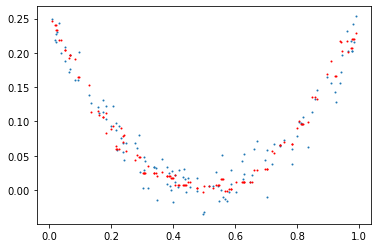

In [144]:
plt.scatter(X_val.squeeze(), y_val.squeeze(), s=1)
plt.scatter(X_val.squeeze(), y_pred.squeeze(), s=1, c='red')
plt.show()

## Stacking

The last ensemble method we will discuss in this chapter is called stacking (short for stacked generalization).
It is based on a simple idea: Instead of using trivial functions (such as hard voting) to aggregate the predictions of all predictors in an ensemble, Why don't we train a model to do that for us? 

The final aggregator learner is typically called a **blender** or a **meta-learner**.

The following figure outlines the idea of learning aggregations:

<div style="text-align:center;"><img style="width: 50%;" src="static/imgs/blender.png"></div>

To train a blender, a common approach is to use a holdout set.

We first train predictors on the first holdout set. Then the first layer predictors are used to export predictions of the second held-out set. This ensures that the predictions are clean since the predictors never saw the 2nd held-out instances during training.

The result is that for each instance in the holdout set, we have 3 predictions, the 3 predictions per row will be considered as input for the blender. The blender is trained on this new dataset.

Unfortunately, `scikit-learn` doesn't support stacking directly.

# Exercices

**1. If you have trained five different models on the exact same training data, and they all achieve 95% precision, is there any chance that you can combine these models to get better results? If so, How? If not, Why?**

Yes, we can combine their predictions:
- Classification Problems
    - hard voting (`y_hat=mode(preds)`)
    - soft voting for classification (averaging estimated class probabilities and taking the class associated with the highest one).
- Regression Problems
    - Taking the mean of the predicted values from each model.

**2. What is the difference between hard & soft voting classifiers?**
In Hard voting, we take all of the predictions and output the mode (the most frequently predicted class). In Soft voting, we average all probabilities associated with each class and output the class with the highest averaged probability.

**3. Is it possible to speed up training of a bagging ensemble by distributing it across multiple servers? What about pasting ensembles? Boosting ensembles, random forests, stacking ensembles?**

- Bagging Ensemble (Bootstrap Aggregation — Sampling with replacement + feature subsetting): It is parallelizable.
- Pasting Ensemble (Only difference — Sampling without replacement): It is parallelizable.
- Boosting Ensemble (Trains predictors sequentially): Not parallelizable.
- Random Forests: Parallelizable.
- Stacking Ensemble: Stacking is partly parallelizable, we can train massive predictors in the first layer but we have to wait for the ith training phase to finish before training subsequent layers (and the final blender).

**4. What is the benefit of out-of-bag evaluation?**

If we use subsets from the training dataset while training, we can evaluate each individual predictor on the unsampled data and estimate the overall performance of the ensemble model without having a hold-out validation set.

**5. What makes Extra-Trees more random than regular random forests? How can this extra randomness help? Are extra trees slower or faster than regular random forests?**

Extra-Trees are more random than regular random forests in that they choose a subset of features to select from at each split and they don't necessary choose the best threshold but they take random thresholds.

This added randomness helps in creating much more varied trees and helps in training a good model.

Extra-trees are faster then regular random forests because they don't have to check for the best split on all features and thresholds, but extra-trees aren't faster then random forests in inference time.

**6. If your Adaboost ensemble underfits the training data, which hyper-parameters should you tweak and how?**

We should increase the number of estimators and reduce the regularization hyper-parameters for the base estimator.

We can also increase the learning rate.

Finally, we can try decreasing $\eta$ so that weights are not extreme.

**7. If your gradient boosting ensemble overfits the training set, should you increase or decrease the learning rate?** 

We should decrease the learning rate because it shrinks the contribution of each tree.

**8. Load MNIST data, and split it into a training set, a validation set, and a test set (Use 50k instances for training, 10k for validation, and 10k for testing)**

In [75]:
X, y = datasets.fetch_openml(name='mnist_784', return_X_y=True)
X.shape, y.shape

((70000, 784), (70000,))

Let's shuffle and sample:

In [76]:
random_indices = np.random.permutation(X.shape[0])

In [77]:
X = X[random_indices]
y = y[random_indices]

We verify that it's fine:

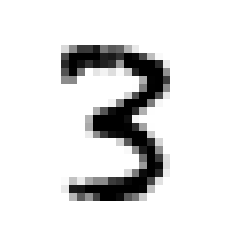

In [78]:
plt.imshow(X[33].reshape(28, 28), cmap='binary')
plt.axis('off')
plt.show()

In [79]:
y[33]

'3'

Let's split it:

In [80]:
X_train, y_train = X[:50000], y[:50000]
X_val, y_val = X[50000:60000], y[50000:60000]
X_test, y_test = X[60000:], y[60000:]
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((50000, 784), (50000,), (10000, 784), (10000,), (10000, 784), (10000,))

I don't have enough compute power, let's take 10% of each dataset:

In [81]:
X_train, y_train = X_train[:5000], y_train[:5000]
X_val, y_val = X_val[:1000], y_val[:1000]
X_test, y_test = X_test[:1000], y_test[:1000]
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((5000, 784), (5000,), (1000, 784), (1000,), (1000, 784), (1000,))

**Train a Random Forests Classifier, an Extra-Trees classifier, & an SVM classifier**

In [82]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score as acc

In [128]:
rfc = RandomForestClassifier(n_estimators=10)
etc = ExtraTreesClassifier(n_estimators=10)
svc = SVC(probability=True)

In [129]:
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [107]:
etc.fit(X_train, y_train)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
                     max_depth=None, max_features='auto', max_leaf_nodes=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
                     oob_score=False, random_state=None, verbose=0,
                     warm_start=False)

In [108]:
svc.fit(X_train, y_train)

/Users/mohamedakramzaytar/opt/miniconda3/envs/research/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=True, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [109]:
acc(y_val, rfc.predict(X_val)), acc(y_val, etc.predict(X_val)), acc(y_val, svc.predict(X_val))

(0.892, 0.882, 0.096)

**Try to combine them into an ensemble that outperforms each individual classifier on the validation set, using soft or hard voting**

In [110]:
from sklearn.ensemble import VotingClassifier

In [111]:
hard_voter = VotingClassifier(estimators=[('random forest', rfc), 
                                          ('extra trees', etc), 
                                          ('support vector classifier', svc)], 
                              n_jobs=-1)

In [112]:
hard_voter.fit(X_train, y_train)

VotingClassifier(estimators=[('random forest',
                              RandomForestClassifier(bootstrap=True,
                                                     class_weight=None,
                                                     criterion='gini',
                                                     max_depth=None,
                                                     max_features='auto',
                                                     max_leaf_nodes=None,
                                                     min_impurity_decrease=0.0,
                                                     min_impurity_split=None,
                                                     min_samples_leaf=1,
                                                     min_samples_split=2,
                                                     min_weight_fraction_leaf=0.0,
                                                     n_estimators=10,
                                                     n_jobs=None,


In [113]:
soft_voter = VotingClassifier(estimators=[('random forest', rfc), 
                                          ('extra trees', etc), 
                                          ('support vector classifier', svc)],
                              voting='soft',
                              n_jobs=-1)

In [114]:
soft_voter.fit(X_train, y_train)

VotingClassifier(estimators=[('random forest',
                              RandomForestClassifier(bootstrap=True,
                                                     class_weight=None,
                                                     criterion='gini',
                                                     max_depth=None,
                                                     max_features='auto',
                                                     max_leaf_nodes=None,
                                                     min_impurity_decrease=0.0,
                                                     min_impurity_split=None,
                                                     min_samples_leaf=1,
                                                     min_samples_split=2,
                                                     min_weight_fraction_leaf=0.0,
                                                     n_estimators=10,
                                                     n_jobs=None,


In [115]:
acc(y_val, hard_voter.predict(X_val))

0.875

In [116]:
acc(y_val, soft_voter.predict(X_val))

0.919

**Once you have found one, try it on the test set. How much better does it perform compared to the individual classifiers?**

In [117]:
acc(y_test, rfc.predict(X_test)), acc(y_val, etc.predict(X_val)), acc(y_test, svc.predict(X_test))

(0.88, 0.882, 0.103)

In [118]:
acc(y_test, hard_voter.predict(X_test))

0.864

In [119]:
acc(y_test, soft_voter.predict(X_test))

0.909

**9. Run the previous classifiers from the previous exercice to make predictions on the validation set, and create a new training set with the resulting predictions**

In [121]:
etc_preds = etc.predict(X_val)[..., None]
rfc_preds = rfc.predict(X_val)[..., None]
svc_preds = svc.predict(X_val)[..., None]
etc_preds.shape, rfc_preds.shape, svc_preds.shape

((1000, 1), (1000, 1), (1000, 1))

**Each training instance is a vector containing the set of predictions from all your classifiers for an image, and the target is the class image. Train a classifier on this new training set**

In [125]:
X_val_ = np.concatenate((etc_preds, rfc_preds, etc_preds), axis=1)
X_val_.shape

(1000, 3)

In [126]:
rfc_ = RandomForestClassifier(n_estimators=10)

In [127]:
rfc_.fit(X_val_, y_val)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

**Congratulations, you have just trained a blender, and together with the classifiers it forms a stacking ensemble!**

**Now evaluate the ensemble on the test set.**
1. For each image in the test set, make predictions with all your classifiers
2. feed the predictions to the blender to get the ensemble’s predictions.
3. How does it compare to the voting classifier you trained earlier?

In [130]:
etc_preds = etc.predict(X_test)[..., None]
rfc_preds = rfc.predict(X_test)[..., None]
svc_preds = svc.predict(X_test)[..., None]

In [131]:
X_test_ = np.concatenate((etc_preds, rfc_preds, etc_preds), axis=1)

In [132]:
y_test_ = rfc_.predict(X_test_)

In [133]:
acc(y_test, y_test_)

0.887

It does better than the hard voter and worse then the softvoter.

---